In [3]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import colormaps

sys.path.append("C:/Users/haoyu/Documents/GitHub/XRaySimulation")

from XRaySimulation import Pulse, DeviceSimu, util, Crystal

plt.rcParams.update({'font.size': 14})


# Definition
1. um, fs, keV
2. normal is pointing inwards the reflection surface

In [4]:
(10.5e6 + 614316 + 227304) / 1e6

11.34162

In [5]:
def prepare_beam_optics(miniSD_grating_position_1=3e6,
                        miniSD_grating_position_2=3e6,
                        miniSD_grating_period=1.0,
                        TG_grating_period=0.5,
                        TG_grating_position=2e6,
                        TG_mirror_probe_angle=np.deg2rad(np.array([0.1e-3, 12.012])),
                        TG_mirror_probe_position=np.array([2.5e6, 11000072.88]),
                        TG_mirror_pump_angle_y=np.deg2rad(np.array([0.4, 0.4])),
                        TG_mirror_pump_position=np.array([10.5e6 + 614316, 10.5e6 + 198379 + 336504 + 43978]),
                        ):
    """
    
    :param miniSD_grating_position_1: 
    :param miniSD_grating_position_2: 
    :param TG_grating_period: 
    :param TG_grating_position: 
    :param TG_mirror_probe_angle: 
    :param TG_mirror_probe_position: 
    :param TG_mirror_pump_angle_y: 
    :param TG_mirror_pump_position: 
    :return: 
    """
    # Specify the parameter here
    # --------------------------------------------------
    # X-ray parameter before the miniSD
    Ec = 9.5  # photon central energy in keV
    FWHM = 50  # beam transverse size in intensity FWHM (um)
    crystal_property = {'d': 1.9201 * 1e-4,
                        "chi0": complex(-0.97631E-05, 0.14871E-06),
                        "chih_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chihbar_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chih_pi": complex(0.46945E-05, -0.11201E-06),
                        "chihbar_pi": complex(0.46945E-05, -0.11201E-06),
                        }
    pre_length = 1e6

    my_pulse = Pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=Ec,
                                  polar=[1., 0., 0.],
                                  sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=9.,
                                  x0=np.array([0., 0., -pre_length - miniSD_grating_position_1]))

    # ----------------------------------------------------
    # Define gratings for the miniSD
    miniSD_gratings_cc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                   order=-1.),
                          Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                   order=1.)]

    miniSD_gratings_vcc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                    order=1.),
                           Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                    order=-1.)]

    # -----------------------------------------------------
    # Define grating for the TG
    TG_grating_a = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=1.)
    TG_grating_b = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=-1.)
    # ----------------------------------------------------
    # Define mirror for the pump pulse
    TG_mirror_pump_a = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[0]]),
                                                     normal=np.array([0,
                                                                      np.cos(TG_mirror_pump_angle_y[0]),
                                                                      np.sin(TG_mirror_pump_angle_y[0])]))
    TG_mirror_pump_b = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[1]]),
                                                     normal=np.array([0,
                                                                      -np.cos(TG_mirror_pump_angle_y[1]),
                                                                      np.sin(TG_mirror_pump_angle_y[1])]))

    # Define mirror for the probe pulse
    TG_mirror_probe_list = [Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_probe_position[0]]),
                                                          normal=np.array([-np.cos(TG_mirror_probe_angle[0]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[0])])),
                            Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_probe_position[1]]),
                                                          normal=np.array([np.cos(TG_mirror_probe_angle[1]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[1])]))]

    # -------------------------------------------------------------------------
    #                         VCC branch
    vcc_channel_cut_config = ["lower left", 'upper left', 'upper left', 'lower left']
    vcc_channel_cut_angles = np.deg2rad(np.array([[0, -5], [5., 0], [0, 5], [-5, 0]]))
    vcc_channel_cut_edge_length_list = np.array([[50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 [50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 ])
    vcc_channel_cut_locations = np.array([[0, 0, 250e3],
                                          [0, 13.595e3, 250e3 + 178e3 - 32.5e3],
                                          [0, 0, 650e3, ],
                                          [0, -13.595e3, 650e3 + 175e3 + 32.5e3]])

    vcc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                           miller_index="220",
                                           energy_keV=Ec,
                                           thickness_list=np.array([1e4, 1e4]),
                                           gap=13.595e3,
                                           surface_center_offset=32.5e3,
                                           edge_length_list=vcc_channel_cut_edge_length_list[_x],
                                           asymmetry_angle_list=vcc_channel_cut_angles[_x],
                                           first_surface_loc=vcc_channel_cut_config[_x],
                                           source=None,
                                           crystal_property=crystal_property)
                        for _x in range(4)]
    # Change the location of the crystals
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=vcc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_vcc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1, 0, 1]
    for idx in range(4):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=vcc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     vcc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # -----------------------------------------------------------------------------------
    #                      CC branch
    cc_channel_cut_config = ["upper left", 'lower left', ]
    cc_channel_cut_angles = np.deg2rad(np.array([[0, 0], [0, 0]]))
    cc_channel_cut_edge_length_list = np.array([[40e3, 100e3],
                                                [120e3, 15e3]])
    cc_channel_cut_center_offset = [30e3, 52.5e3]
    cc_channel_cut_gap = [25.15e3, 25.8e3]
    cc_channel_cut_locations = np.array([[0, 0, 0],
                                         [0, -cc_channel_cut_gap[1], 1050e3 - cc_channel_cut_center_offset[1]], ])

    cc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                          miller_index="220",
                                          energy_keV=Ec,
                                          thickness_list=np.array([1e4, 1e4]),
                                          gap=cc_channel_cut_gap[_x],
                                          surface_center_offset=cc_channel_cut_center_offset[_x],
                                          edge_length_list=cc_channel_cut_edge_length_list[_x],
                                          asymmetry_angle_list=cc_channel_cut_angles[_x],
                                          first_surface_loc=cc_channel_cut_config[_x],
                                          source=None,
                                          crystal_property=crystal_property)
                       for _x in range(2)]

    # ------------------------------------------------------------------------------------
    # Change location of CC crystals
    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=cc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_cc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1]
    for idx in range(2):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=cc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     cc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # ---------------------------------------------------------------
    # Change the position of the TG optics according to the input parameters

    return (my_pulse, miniSD_gratings_cc, miniSD_gratings_vcc,
            vcc_channel_cuts, cc_channel_cuts,
            TG_grating_a, TG_grating_b,
            TG_mirror_pump_a, TG_mirror_pump_b, TG_mirror_probe_list)

In [6]:
def get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                 displacement_list_cc=np.zeros((2, 3)),
                                 displacement_list_TG_probe=np.zeros((2, 3)),
                                 displacement_list_TG_pump=np.zeros((2, 3)),
                                 rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                 rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                 sample_plane_position=np.array([0, 0, 11e6]),
                                 sample_plane_normal=np.array([0, 0, -1]),
                                 ):
    """
    After thinking about this for a very long time, 
    I decided to define this clumsy function for this experiment only.
    
    Of course, I could have done this in a more general way such that
    the function can be resued for miniSD operation only.
    However, I do not have the bandwidth to do so at this moment.
    Therefore, I have to put everything together and hope to improve my 
    efficiency a little bit in this way.
     
    
    :param displacement_list_vcc: 
    :param displacement_list_cc: 
    :return: 
    """
    # Create a initial copy of the devices 
    (my_pulse,
     miniSD_gratings_cc,
     miniSD_gratings_vcc,
     vcc_channel_cuts,
     cc_channel_cuts,
     TG_grating_a,
     TG_grating_b,
     TG_mirror_pump_a,
     TG_mirror_pump_b,
     TG_mirror_probe_list) = prepare_beam_optics()

    # Move crystals in the miniSD as needed
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=displacement_list_vcc[idx])

    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=displacement_list_cc[idx])

    # Move devices in the TG optics as needed
    for idx in range(2):
        TG_mirror_probe_list[idx].shift(displacement_list_TG_probe[idx])
        TG_mirror_probe_list[idx].rotate(rot_mat=rotation_list_GT_probe[idx])

    # Move the TG pump optics as needed
    TG_mirror_pump_a.shift(displacement=displacement_list_TG_pump[0])
    TG_mirror_pump_a.rotate(rot_mat=rotation_list_GT_pump[0])
    TG_mirror_pump_b.shift(displacement=displacement_list_TG_pump[1])
    TG_mirror_pump_b.rotate(rot_mat=rotation_list_GT_pump[1])

    # Get a trajectory with this setting to find time 0
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_vcc[1], ]

    # Get the tranjectory for the miniSD VCC branch
    (vcc_trajectory_local,
     vcc_kout_list_local,
     vcc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                                kin=my_pulse.k0,
                                                initial_point=my_pulse.x0,
                                                final_plane_point=sample_plane_position,
                                                final_plane_normal=sample_plane_normal)

    # Get the tranjectory for the miniSD CC branch
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_cc[1], ]

    (cc_trajectory_local,
     cc_kout_list_local,
     cc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                               kin=my_pulse.k0,
                                               initial_point=my_pulse.x0,
                                               final_plane_point=sample_plane_position,
                                               final_plane_normal=sample_plane_normal)

    # Get the trajectory for the TG probe branch
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += TG_mirror_probe_list

    # Get the tranjectory for the miniSD VCC branch
    (TG_probe_trajectory,
     TG_probe_kout_list,
     TG_probe_ligthPathLength) = DeviceSimu.get_lightpath(device_list=device_list,
                                                          kin=my_pulse.k0,
                                                          initial_point=my_pulse.x0,
                                                          final_plane_point=sample_plane_position,
                                                          final_plane_normal=sample_plane_normal)
   
    # Get the trajectory for the TG pump branch 0
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list

    # Get the tranjectory for the TG pump branch 0 which is also the reference branch
    (TG_pump_trajectory_0,
     TG_pump_kout_list_0,
     TG_pump_ligthPathLength_0) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)
   
    # Get the trajectory for the TG pump branch a
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_a, TG_mirror_pump_a]

    # Get the tranjectory for the miniSD VCC branch
    (TG_pump_trajectory_a,
     TG_pump_kout_list_a,
     TG_pump_ligthPathLength_a) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    # Get the trajectory for the TG pump branch b
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_b, TG_mirror_pump_b]

    # Get the tranjectory for the miniSD VCC branch
    (TG_pump_trajectory_b,
     TG_pump_kout_list_b,
     TG_pump_ligthPathLength_b) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    return {"devices": {'pulse': my_pulse,
                        "sd grating cc": miniSD_gratings_cc,
                        "sd grating vcc": miniSD_gratings_vcc,
                        "vcc": vcc_channel_cuts,
                        "cc": cc_channel_cuts,
                        "tg grating a": TG_grating_a,
                        "tg grating b": TG_grating_b,
                        'tg mirror pump a': TG_mirror_pump_a,
                        'tg mirror pump b': TG_mirror_pump_b,
                        'tg mirror probe': TG_mirror_probe_list,
                        },
            "vcc": {"trajectory": vcc_trajectory_local,
                    "kout": vcc_kout_list_local,
                    "pathLength": vcc_path_local},
            "cc": {"trajectory": cc_trajectory_local,
                   "kout": cc_kout_list_local,
                   "pathLength": cc_path_local},
            "TG probe": {"trajectory": TG_probe_trajectory,
                         "kout": TG_probe_kout_list,
                         "pathLength": TG_probe_ligthPathLength},
            "TG pump a": {"trajectory": TG_pump_trajectory_a,
                          "kout": TG_pump_kout_list_a,
                          "pathLength": TG_pump_ligthPathLength_a},
            "TG pump b": {"trajectory": TG_pump_trajectory_b,
                          "kout": TG_pump_kout_list_b,
                          "pathLength": TG_pump_ligthPathLength_b},
            "TG pump 0": {"trajectory": TG_pump_trajectory_0,
                          "kout": TG_pump_kout_list_0,
                          "pathLength": TG_pump_ligthPathLength_0},
            }

In [7]:
def get_coefficient_for_two_configurations(config1, config2):
    # Get the influence on the VCC branch position
    sd_vcc_position_coef = config1['vcc']['trajectory'][-1] - config2['vcc']['trajectory'][-1]

    # Get the influence on the VCC path length
    sd_vcc_pathLength_coef = config1['vcc']['pathLength'] - config2['vcc']['pathLength']

    # Get the influence on the TG probe position
    tg_probe_position_coef = config1['TG probe']['trajectory'][-1] - config2['TG probe']['trajectory'][-1]

    # Get the influence on the TG probe path length  
    tg_probe_pathLength_coef = config1['TG probe']['pathLength'] - config2['TG probe']['pathLength']

    # Get the influence on the TG branch 1 position
    tg_pump_a_position_coef = config1['TG pump a']['trajectory'][-1] - config2['TG pump a']['trajectory'][-1]

    # Get the influence on the TG branch 1 path length
    tg_pump_a_pathLength_coef = config1['TG pump a']['pathLength'] - config2['TG pump a']['pathLength']

    # Get the influence on the TG branch 2 position
    tg_pump_b_position_coef = config1['TG pump b']['trajectory'][-1] - config2['TG pump b']['trajectory'][-1]

    # Get the influence on the TG branch s path length
    tg_pump_b_pathLength_coef = config1['TG pump b']['pathLength'] - config2['TG pump b']['pathLength']

    # Get the influence on the position on the Bragg mirror
    tg_probe_bragg_position_coef = config1['TG probe']['trajectory'][-2] - config2['TG probe']['trajectory'][-2]

    collect_coef = {"vcc": {"position": sd_vcc_position_coef,
                            "pathLength": sd_vcc_pathLength_coef},
                    "probe": {"position": tg_probe_position_coef,
                              "pathLength": tg_probe_pathLength_coef},
                    "probe bragg": {"position": tg_probe_bragg_position_coef},
                    "pump a": {"position": tg_pump_a_position_coef,
                               "pathLength": tg_pump_a_pathLength_coef},
                    "pump b": {"position": tg_pump_b_position_coef,
                               "pathLength": tg_pump_b_pathLength_coef},
                    }
    return collect_coef


def get_trajectory_dependence_on_various_parameters():
    """
    The purpose of this function is to calculate the dependence on various 
    crystal parameter on the resulting optics trajectory and 
    light path length dependene.
    
    :return: 
    """
    # Calculate the current trajectories for different light paths
    current = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                           displacement_list_cc=np.zeros((2, 3)),
                                           displacement_list_TG_probe=np.zeros((2, 3)),
                                           displacement_list_TG_pump=np.zeros((2, 3)),
                                           rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                           rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                           sample_plane_position=np.array([0, 0, 11e6]),
                                           sample_plane_normal=np.array([0, 0, -1]), )

    # T2x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 1, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t2x_coef = get_coefficient_for_two_configurations(new, current)

    # T3x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 1, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t3x_coef = get_coefficient_for_two_configurations(new, current)

    # T4x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 1, 0], [0, 0, 0]]))
    t4x_coef = get_coefficient_for_two_configurations(new, current)

    # T5x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 1, 0]]))
    t5x_coef = get_coefficient_for_two_configurations(new, current)

    # probe1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 1], [0, 0, 0]]))
    probe1z_coef = get_coefficient_for_two_configurations(new, current)

    # probe1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_probe=np.array([[[np.cos(1e-6), 0, np.sin(1e-6)],
                                                                         [0, 1, 0],
                                                                         [-np.sin(1e-6), 0, np.cos(1e-6)]],
                                                                        np.eye(3)]))
    probe1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # probe2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 0], [0, 0, 1]]))
    probe2z_coef = get_coefficient_for_two_configurations(new, current)

    # probe2_alpha + 1urad
    # This is ignored since the second mirror is essentially a crystal
    # Therefore it is better if we optimize the intensity rather than the tune it.

    # TG1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 1], [0, 0, 0]]))
    pump1z_coef = get_coefficient_for_two_configurations(new, current)

    # TG1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_pump=np.array([[[1, 0, 0],
                                                                        [0, np.cos(1e-6), np.sin(1e-6)],
                                                                        [0, -np.sin(1e-6), np.cos(1e-6)]],
                                                                       np.eye(3)]))
    pump1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # TG2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 0], [0, 0, 1]]))
    pump2z_coef = get_coefficient_for_two_configurations(new, current)

    # TG2_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_pump=np.array([np.eye(3),
                                                                       [[1, 0, 0],
                                                                        [0, np.cos(1e-6), np.sin(1e-6)],
                                                                        [0, -np.sin(1e-6), np.cos(1e-6)]]
                                                                       ]))
    pump2alpha_coef = get_coefficient_for_two_configurations(new, current)

    return (t2x_coef, t3x_coef, t4x_coef, t5x_coef,
            probe1z_coef, probe1alpha_coef, probe2z_coef,
            pump1z_coef, pump1alpha_coef, pump2z_coef, pump2alpha_coef)


In [8]:
expSimu = get_miniSD_and_TG_trajectory()
(t2x_coef, t3x_coef, t4x_coef, t5x_coef,
 probe1z_coef, probe1alpha_coef, probe2z_coef,
 pump1z_coef, pump1alpha_coef, pump2z_coef, pump2alpha_coef) = get_trajectory_dependence_on_various_parameters()

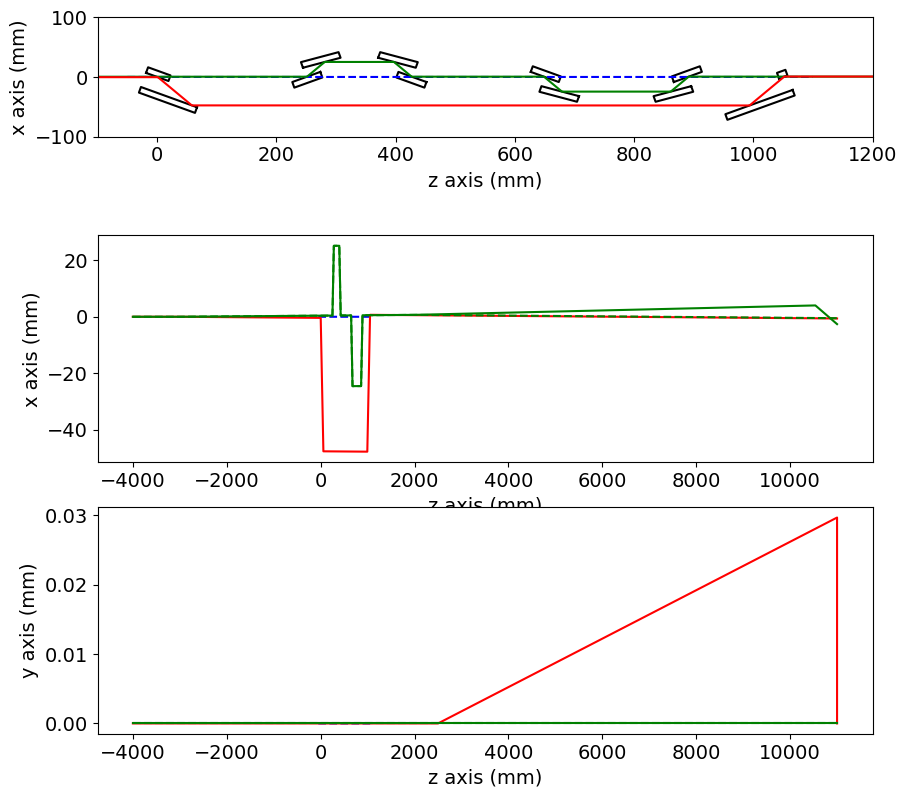

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=3)

fig.set_figheight(10)
fig.set_figwidth(10)

# --------------------------------------------------------------------------
# Show the trajectory of the miniSD region
cmap = colormaps.get_cmap('spring')
for x in range(4):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')
        #c=cmap((x * 2 + idx) / 8))

for x in range(2):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')

# Plot a horizontal reference line
axes[0].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[0].plot(expSimu['vcc']['trajectory'][:, 2] / 1000,
             expSimu['vcc']['trajectory'][:, 1] / 1000, 'g')

axes[0].plot(expSimu['cc']['trajectory'][:, 2] / 1000,
             expSimu['cc']['trajectory'][:, 1] / 1000, 'r')

axes[0].set_aspect("equal")
axes[0].set_ylim([-100, 100])
axes[0].set_xlim([-100, 1200])
axes[0].set_xlabel("z axis (mm)")
axes[0].set_ylabel("x axis (mm)")
# --------------------------------------------------------------------------
# Show the TG part in the x-z plane

# Plot a horizontal reference line
axes[1].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[1].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 1] / 1000, 'r')

axes[1].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 1] / 1000, 'g')

axes[1].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 1] / 1000, 'g--')

axes[1].set_xlabel("z axis (mm)")
axes[1].set_ylabel("x axis (mm)")

#axes[1].set_aspect("equal")
#axes[1].set_ylim([-10, 10])
#axes[1].set_xlim([-100, 1200])

# --------------------------------------------------------------------------
# Show the TG part in the y-z plane

# Plot a horizontal reference line
axes[2].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[2].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 0] / 1000, 'r')

axes[2].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 0] / 1000, 'g')

axes[2].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 0] / 1000, 'g--')

#axes[2].set_aspect("equal")
#axes[2].set_ylim([-10, 10])
#axes[2].set_xlim([1000, 1200])

axes[2].set_xlabel("z axis (mm)")
axes[2].set_ylabel("y axis (mm)")

plt.show()

# Step 2 Optimize the spatial overlap between the two TG branches

#-------------------------------------------
For TG pump pulse a
Position on the sample
[ 0.00000000e+00 -2.60637273e+03  1.10000000e+07]

For TG pump pulse b
Position on the sample
[ 0.00000000e+00 -6.04982712e+02  1.10000000e+07]

Pump position with pump1z + 1um
[0.         0.01396358 0.        ]
Pump position with pump1alpha + 1urad
[ 0.         -0.22855717  0.        ]

Pump position with pump2z + 1um
[ 0.         -0.01396355  0.        ]
Pump position with pump2alpha + 1urad
[0. 0. 0.]

Pump path length with pump1z + 1um
-9.748712182044983e-05
Pump path length with pump1alpha + 1urad
-0.005213512107729912

Pump path length with pump2z + 1um
-9.748898446559906e-05
Pump path length with pump2alpha + 1urad
-0.0012102443724870682


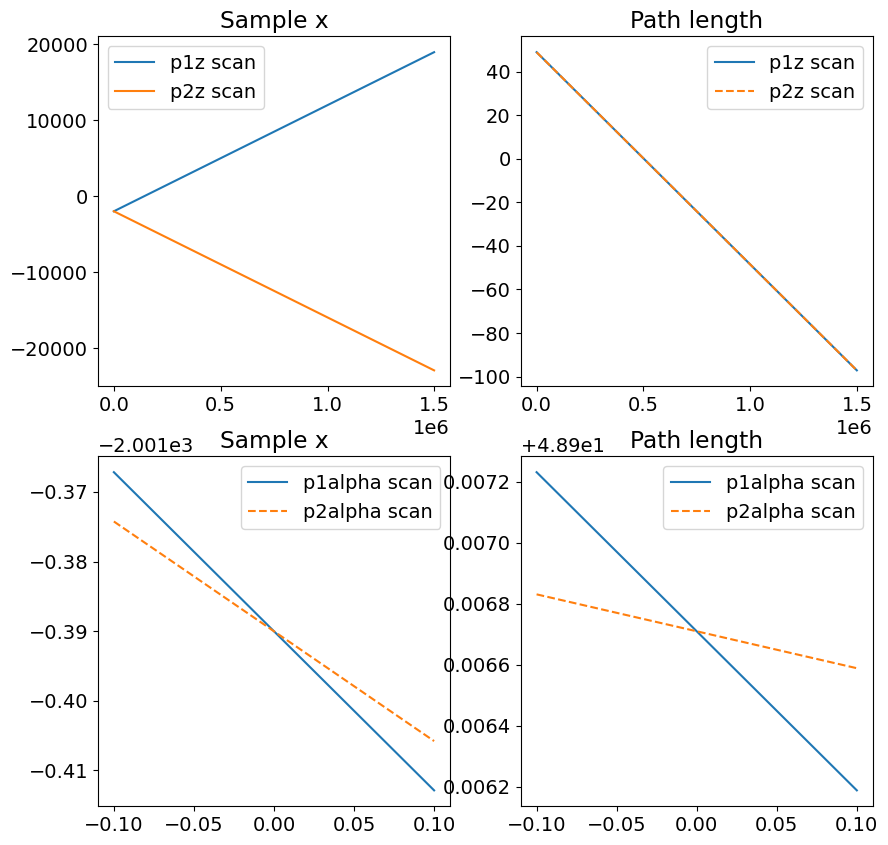

In [10]:
# To avoid potential sample collision:
# We need to make sure that the vertical offset between the Bragg mirror and the sample is larger than 3~mm
print("#-------------------------------------------")
print("For TG pump pulse a")
# Adjust the position of the probe pulse such that the y=0
print("Position on the sample")
print(expSimu['TG pump a']['trajectory'][-1])
print()

print("For TG pump pulse b")
print("Position on the sample")
print(expSimu['TG pump b']['trajectory'][-1])
print()

# Get the dependence on the z position of the probe crystal position
print("Pump position with pump1z + 1um")
print(pump1z_coef['pump a']['position'])
print("Pump position with pump1alpha + 1urad")
print(pump1alpha_coef['pump a']['position'])
print()

print("Pump position with pump2z + 1um")
print(pump2z_coef['pump b']['position'])
print("Pump position with pump2alpha + 1urad")
print(pump2alpha_coef['pump a']['position'])
print()

print("Pump path length with pump1z + 1um")
print(pump1z_coef['pump a']['pathLength'])
print("Pump path length with pump1alpha + 1urad")
print(pump1alpha_coef['pump a']['pathLength'])
print()

print("Pump path length with pump2z + 1um")
print(pump2z_coef['pump b']['pathLength'])
print("Pump path length with pump2alpha + 1urad")
print(pump2alpha_coef['pump b']['pathLength'])
print()

# Plot the figure showing the change of the position the sample as a function 
# of the relative position compared with current setting. 
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)

p1z_scan = np.arange(1000) * 1500
p1z_sample_x = p1z_scan * pump1z_coef['pump a']['position'][1]
p1z_sample_x += expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1]

p2z_scan = np.arange(1000) * 1500
p2z_sample_x = p2z_scan * pump2z_coef['pump b']['position'][1]
p2z_sample_x += expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1]

ax[0, 0].plot(p1z_scan, p1z_sample_x, label='p1z scan')
ax[0, 0].plot(p2z_scan, p2z_sample_x, label='p2z scan')
ax[0, 0].legend()
ax[0, 0].set_title("Sample x")

p1z_scan = np.arange(1000) * 1500
p1z_path = p1z_scan * pump1z_coef['pump a']['pathLength']
p1z_path += expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']

p2z_scan = np.arange(1000) * 1500
p2z_path = p2z_scan * pump2z_coef['pump b']['pathLength']
p2z_path += expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']

ax[0, 1].plot(p1z_scan, p1z_path, label='p1z scan')
ax[0, 1].plot(p2z_scan, p2z_path, '--', label='p2z scan')
ax[0, 1].legend()
ax[0, 1].set_title("Path length")

p1alpha_scan = np.linspace(-0.1, 0.1, 100)
p1alpha_sample_x = p1alpha_scan * pump1alpha_coef['pump a']['position'][1]
p1alpha_sample_x += expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1]

p2alpha_scan = np.linspace(-0.1, 0.1, 100)
p2alpha_sample_x = p2alpha_scan * pump2alpha_coef['pump b']['position'][1]
p2alpha_sample_x += expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1]

ax[1, 0].plot(p1alpha_scan, p1alpha_sample_x, label='p1alpha scan')
ax[1, 0].plot(p2alpha_scan, p2alpha_sample_x, '--', label='p2alpha scan')
ax[1, 0].legend()
ax[1, 0].set_title("Sample x")

p1alpha_scan = np.linspace(-0.1, 0.1, 100)
p1alpha_path = p1alpha_scan * pump1alpha_coef['pump a']['pathLength']
p1alpha_path += expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']

p2alpha_scan = np.linspace(-0.1, 0.1, 100)
p2alpha_path = p2alpha_scan * pump2alpha_coef['pump b']['pathLength']
p2alpha_path += expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']

ax[1, 1].plot(p1alpha_scan, p1alpha_path, label='p1alpha scan')
ax[1, 1].plot(p2alpha_scan, p2alpha_path, '--', label='p2alpha scan')
ax[1, 1].legend()
ax[1, 1].set_title("Path length")

plt.show()

#### We try to make one branch of the tmp pulse overlap with the probe pulse location by adjusting the position of p2z 

In [11]:
print(expSimu['devices']['tg mirror pump a'].normal)
print(expSimu['devices']['tg mirror pump b'].normal)


[0.         0.99997563 0.00698126]
[ 0.         -0.99997563  0.00698126]


In [12]:
displacement = expSimu['TG probe']['trajectory'][-1] - expSimu["TG pump b"]['trajectory'][-1]
print(displacement)

adjustment = displacement[1] / pump2z_coef['pump b']['position'][1]
print("The p2z needs to adjusted by {:.2f} um".format(adjustment))

[ 0.00025537 -0.01098068  0.        ]
The p2z needs to adjusted by 0.79 um


We need to achieve the following targets:
 1. Spatially they are overlap along the x axis
 2. The path length difference is 0.
 3. The path length is similar to that of the probe pulse
 4. The crossing angle is a fixed value
 5. The spatial sepration is relatively large to make it easier to align optics.

We have 4 variables.

p1z, p1alpha, p2z, p2alpha.

The requirement 4 is achieved automatically if we require the two mirrors rotate together

i.e. p1alpha = p2alpha

The requirement 3 need to reconcil with configurations on the probe branch.
I ignore it at this moment 

For requirement 5, I fix the position of p2z at this moment

For the rest of the requirements, we need to solve linear equations

In [13]:
# The equation is 
#  p1z * pump1z_coef['pump a']['position'][1]
#  + p1alpha *  pump1alpha_coef['pump a']['position'][1] 
#  - p1alpha *  pump2alpha_coef['pump a']['position'][1] 
#  = expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1]
# 
#  p1z * pump1z_coef['pump a']['pathLength']
#  + p1alpha *  pump1alpha_coef['pump a']['pathLength']
#  - p1alpha *  pump2alpha_coef['pump a']['pathLength']
#  = expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']
mat = np.array([[pump1z_coef['pump a']['position'][1],
                 pump1alpha_coef['pump a']['position'][1] - pump2alpha_coef['pump a']['position'][1]],
                [pump1z_coef['pump a']['pathLength'],
                 pump1alpha_coef['pump a']['pathLength'] - pump2alpha_coef['pump a']['pathLength']]])
vec = -np.array([expSimu['TG pump a']['trajectory'][-1][1] - expSimu['TG pump b']['trajectory'][-1][1],
                expSimu['TG pump a']['pathLength'] - expSimu['TG pump b']['pathLength']])
res = np.linalg.solve(mat, vec)

print("The p1z = {} um".format(res[0]))
print("The p1alpha = {} deg".format(np.rad2deg(res[1] * 1e-6)))
print("The p2alpha = {} deg".format(np.rad2deg(-res[1] * 1e-6)))

The p1z = 227304.34942848393 um
The p1alpha = 0.2939509305800892 deg
The p2alpha = -0.2939509305800892 deg


In [14]:
print("We need to achieve the following targets:")
print("1. Spatially they are overlap along the x axis")
print("2. The path length difference is 0.")
print("3. The path length is similar to that of the probe pulse")
print("We have to variables of pump1z and pump2z to achieve the first 2 purpose")
print("The last purpose needs to be adjusted with the probe pulse optics.")
print()


We need to achieve the following targets:
1. Spatially they are overlap along the x axis
2. The path length difference is 0.
3. The path length is similar to that of the probe pulse
We have to variables of pump1z and pump2z to achieve the first 2 purpose
The last purpose needs to be adjusted with the probe pulse optics.


# Step 2: Optimize the vertical offset of the Bragg mirror:

In [15]:
# To avoid potential sample collision:
# We need to make sure that the vertical offset between the Bragg mirror and the sample is larger than 3~mm
print("#-------------------------------------------")
print("For TG probe pulse")
# Adjust the position of the probe pulse such that the y=0
print("Position on the last Bragg mirror")
print(expSimu['TG probe']['trajectory'][-2])
#print("Position on the sample")
#print(expSimu['TG probe']['trajectory'][-1])
print()

# Get the dependence on the z position of the probe crystal position
print("Probe Bragg position coefficient with probe 1z + 1um")
print(probe1z_coef['probe bragg']['position'])
print("Probe Bragg position coefficient with probe 1 alpha + 1urad")
print(probe1alpha_coef['probe bragg']['position'])
print()

# Get the position adjustment required for the overlap
adjustment = (0 - expSimu['TG probe']['trajectory'][-1][0]) / probe2z_coef['probe']['position'][0]
print("Need to change probe 2z by {:.2f} um".format(adjustment))
print("The new surface location of probe 2 is:",
      expSimu['devices']['tg mirror probe'][1].surface_point + np.array([0, 0, adjustment]))

#-------------------------------------------
For TG probe pulse
Position on the last Bragg mirror
[ 2.96703649e+01 -6.04984181e+02  1.09999334e+07]

Probe Bragg position coefficient with probe 1z + 1um
[-3.49060124e-06 -2.14095053e-09  1.64043158e-05]
Probe Bragg position coefficient with probe 1 alpha + 1urad
[ 1.69994282e+01  1.04268965e-02 -7.98937393e+01]

Need to change probe 2z by -0.00 um
The new surface location of probe 2 is: [       0.                0.         11000072.87942707]


 # Step 2 Optimize the position of the probe pulse

In [16]:
print("#-------------------------------------------")
print("For TG probe pulse")
# Adjust the position of the probe pulse such that the y=0
print("Position on the last Bragg mirror")
print(expSimu['TG probe']['trajectory'][-2])
print("Position on the sample")
print(expSimu['TG probe']['trajectory'][-1])
print()
print()

# Get the dependence on the z position of the probe crystal position
print("probe position coefficient with z + 1um")
print(probe2z_coef['probe']['position'])

# Get the position adjustment required for the overlap
adjustment = (0 - expSimu['TG probe']['trajectory'][-1][0]) / probe2z_coef['probe']['position'][0]
print("Need to change probe 2z by {:.2f} um".format(adjustment))
print("The new surface location of probe 2 is:",
      expSimu['devices']['tg mirror probe'][1].surface_point + np.array([0, 0, adjustment]))

#-------------------------------------------
For TG probe pulse
Position on the last Bragg mirror
[ 2.96703649e+01 -6.04984181e+02  1.09999334e+07]
Position on the sample
[ 2.55374165e-04 -6.04993692e+02  1.10000000e+07]


probe position coefficient with z + 1um
[4.45731055e-01 1.23776305e-05 0.00000000e+00]
Need to change probe 2z by -0.00 um
The new surface location of probe 2 is: [       0.                0.         11000072.87942707]


In [17]:
expSimu['TG probe']['trajectory']

array([[ 0.00000000e+00,  0.00000000e+00, -4.00000000e+06],
       [ 0.00000000e+00,  0.00000000e+00, -3.00000000e+06],
       [ 0.00000000e+00, -3.91670449e+02,  1.08348168e+03],
       [ 0.00000000e+00, -4.77054247e+04,  5.79890474e+04],
       [ 0.00000000e+00, -4.78275229e+04,  9.93537575e+05],
       [ 0.00000000e+00,  6.93327967e+02,  1.05191936e+06],
       [ 0.00000000e+00,  5.04339424e+02,  2.50000000e+06],
       [ 2.96703649e+01, -6.04984181e+02,  1.09999334e+07],
       [ 2.55374165e-04, -6.04993692e+02,  1.10000000e+07]])